<a href="https://colab.research.google.com/github/KSundaram17/BERT/blob/main/Pytorch_Bert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install transformers==3.0.0

     |████████████████████████████████| 754 kB 4.1 MB/s 
     |████████████████████████████████| 1.2 MB 33.2 MB/s 
     |████████████████████████████████| 895 kB 36.3 MB/s 
     |████████████████████████████████| 3.0 MB 20.5 MB/s 


In [2]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch

In [3]:
transformers.__version__

'3.0.0'

tqdm is a Python library that allows you to output a smart progress bar by wrapping around any iterable. A tqdm progress bar not only shows you how much time has elapsed, but also shows the estimated time remaining for the iterable.

In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

In [5]:
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)


In [6]:
!nvidia-smi

Tue Aug 24 16:11:35 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   64C    P8    32W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [8]:
device

device(type='cuda', index=0)

In [9]:
!gdown --id 1S6qMioqPJjyBLpLVz4gmRTnJHnjitnuV
!gdown --id 1zdmewp7ayS4js4VtrJEHzAheSW-5NBZv

Downloading...
From: https://drive.google.com/uc?id=1S6qMioqPJjyBLpLVz4gmRTnJHnjitnuV
To: /content/apps.csv
100% 134k/134k [00:00<00:00, 50.6MB/s]
Downloading...
From: https://drive.google.com/uc?id=1zdmewp7ayS4js4VtrJEHzAheSW-5NBZv
To: /content/reviews.csv
7.17MB [00:00, 22.8MB/s]


In [10]:
df = pd.read_csv("reviews.csv")
df = df[:4000]
df.head(2)

,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,sortOrder,appId
0,Andrew Thomas,https://lh3.googleusercontent.com/a-/AOh14GiHd...,Update: After getting a response from the deve...,1,21,4.17.0.3,2020-04-05 22:25:57,"According to our TOS, and the term you have ag...",2020-04-05 15:10:24,most_relevant,com.anydo
1,Craig Haines,https://lh3.googleusercontent.com/-hoe0kwSJgPQ...,Used it for a fair amount of time without any ...,1,11,4.17.0.3,2020-04-04 13:40:01,It sounds like you logged in with a different ...,2020-04-05 15:11:35,most_relevant,com.anydo


In [11]:
df.shape

(4000, 11)

In [12]:
df.info() 
#to check missing values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   userName              4000 non-null   object
 1   userImage             4000 non-null   object
 2   content               4000 non-null   object
 3   score                 4000 non-null   int64 
 4   thumbsUpCount         4000 non-null   int64 
 5   reviewCreatedVersion  3325 non-null   object
 6   at                    4000 non-null   object
 7   replyContent          1982 non-null   object
 8   repliedAt             1982 non-null   object
 9   sortOrder             4000 non-null   object
 10  appId                 4000 non-null   object
dtypes: int64(2), object(9)
memory usage: 343.9+ KB


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


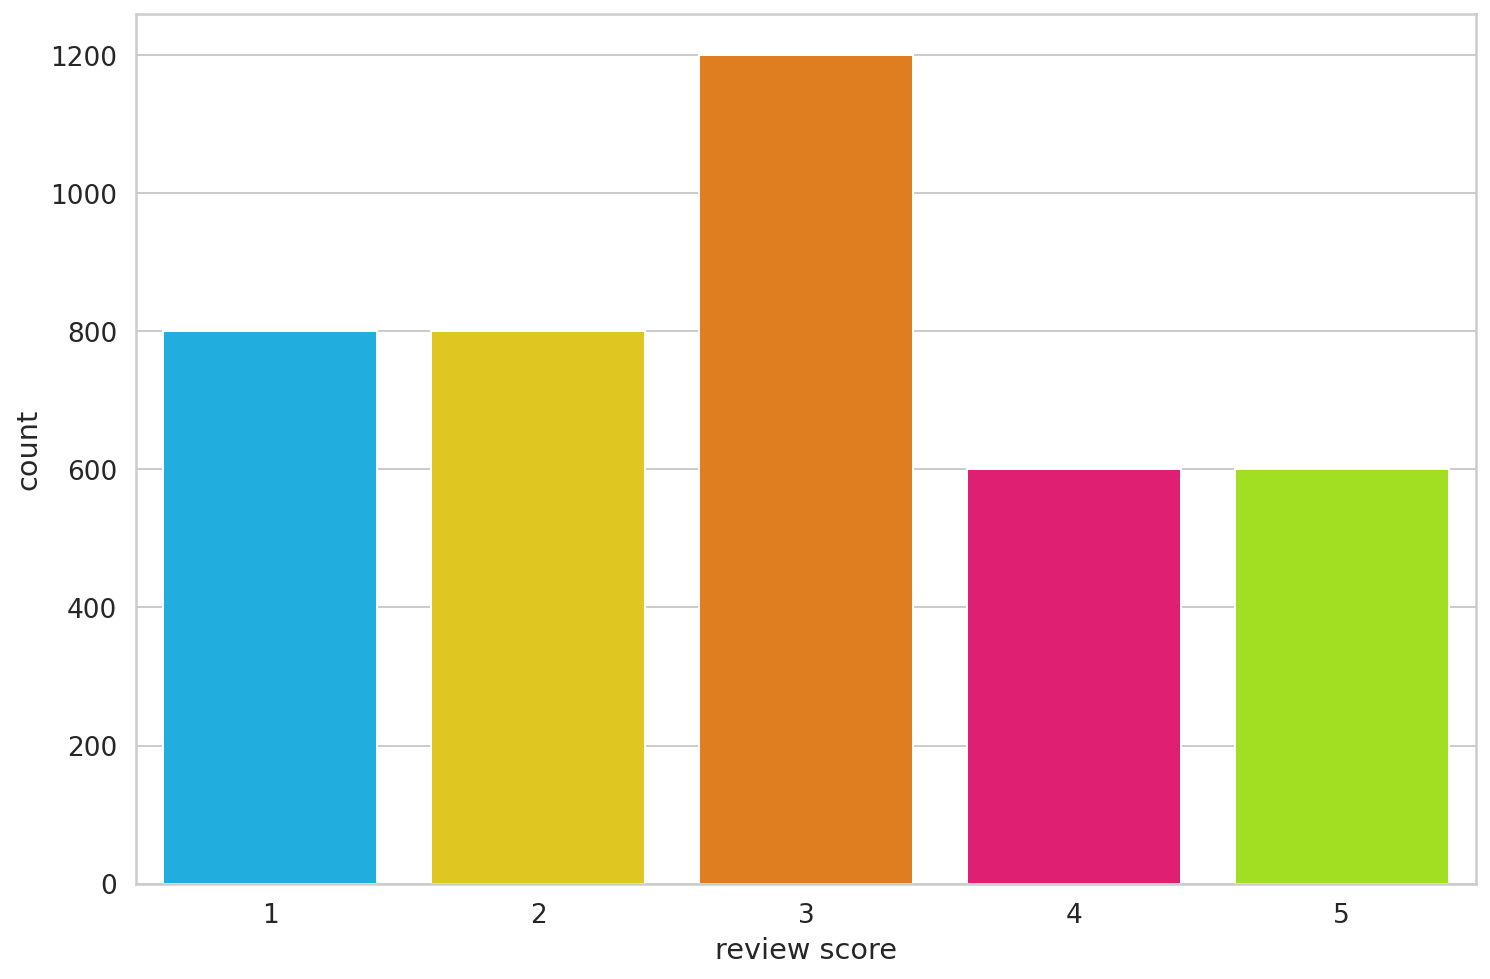

In [13]:
#to check unbalanced classes(skewness)
sns.countplot(df.score)
plt.xlabel('review score');

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


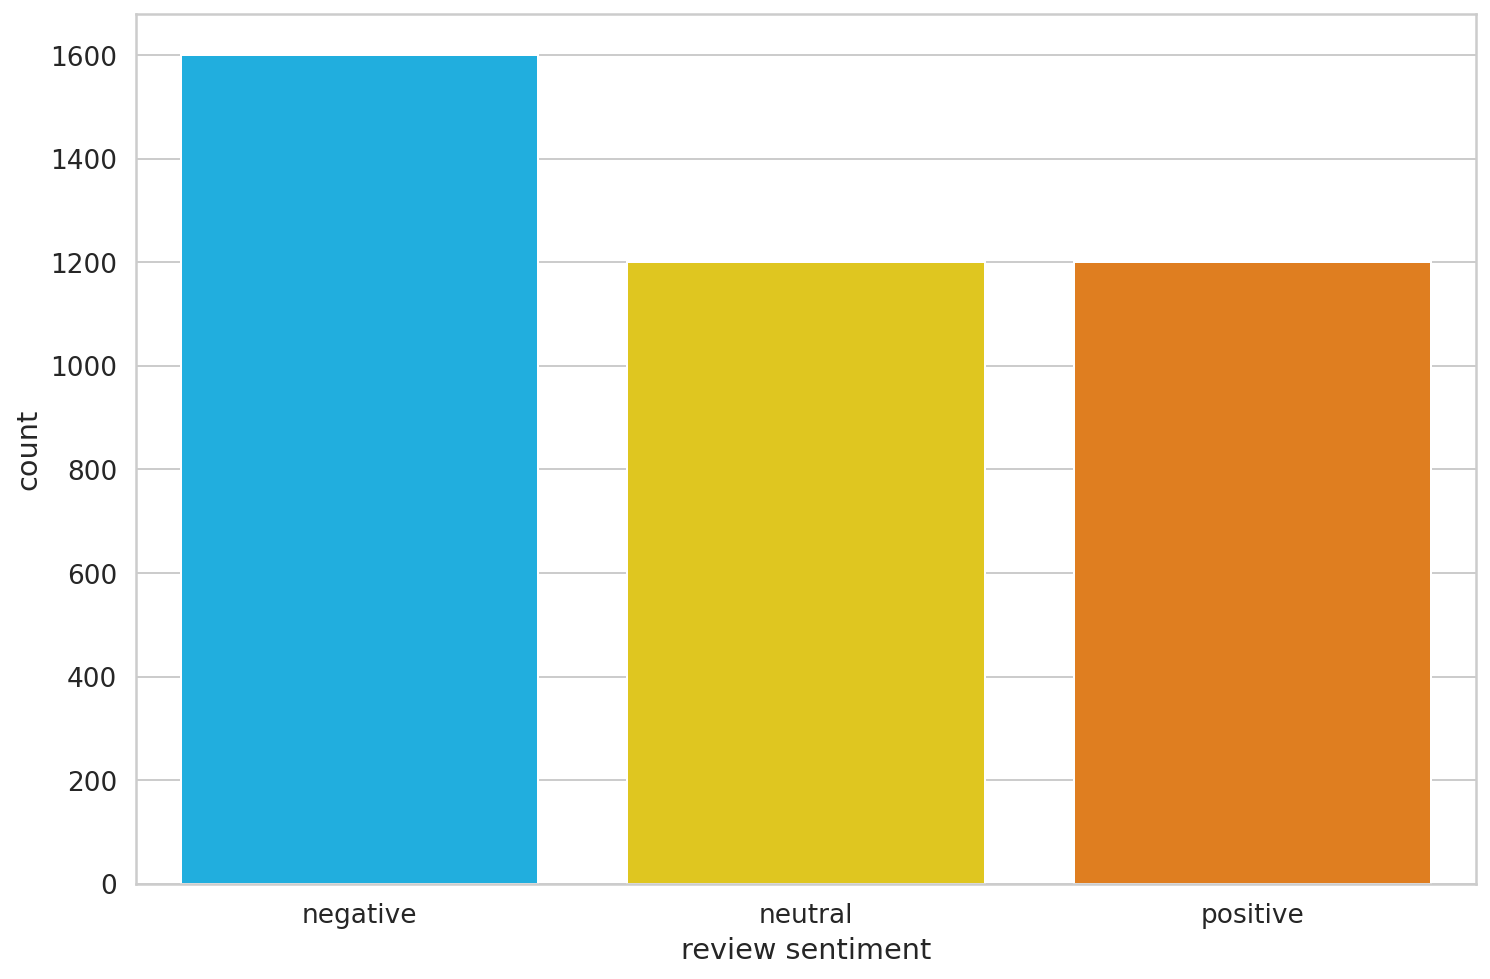

In [14]:
def to_sentiment(rating):
  rating = int(rating)
  if rating <= 2:
    return 0
  elif rating == 3:
    return 1
  else:
    return 2
df['sentiment'] = df.score.apply(to_sentiment)
class_names = ['negative', 'neutral', 'positive']
ax = sns.countplot(df.sentiment)
plt.xlabel('review sentiment')
ax.set_xticklabels(class_names);

In [15]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'

In [16]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

Downloading:   0%|          | 0.00/213k [00:00<?, ?B/s]

In [17]:
sample_txt = 'When was I last outside? I am stuck at home for 2 weeks.'

In [18]:
tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)
print(f' Sentence: {sample_txt}')
print(f'Tokens: {tokens}')
print(f'Token IDs: {token_ids}')

 Sentence: When was I last outside? I am stuck at home for 2 weeks.
Tokens: ['When', 'was', 'I', 'last', 'outside', '?', 'I', 'am', 'stuck', 'at', 'home', 'for', '2', 'weeks', '.']
Token IDs: [1332, 1108, 146, 1314, 1796, 136, 146, 1821, 5342, 1120, 1313, 1111, 123, 2277, 119]


In [19]:
tokenizer.sep_token, tokenizer.sep_token_id

('[SEP]', 102)

In [20]:
tokenizer.cls_token, tokenizer.cls_token_id

('[CLS]', 101)

In [21]:
tokenizer.pad_token, tokenizer.pad_token_id

('[PAD]', 0)

In [22]:
tokenizer.unk_token, tokenizer.unk_token_id

('[UNK]', 100)

In [23]:
encoding = tokenizer.encode_plus(
  sample_txt,
  max_length=32,
  truncation = True,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',  # Return PyTorch tensors
)

encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

In [24]:
print(len(encoding['input_ids'][0]))
encoding['input_ids'][0]

32


tensor([ 101, 1332, 1108,  146, 1314, 1796,  136,  146, 1821, 5342, 1120, 1313,
        1111,  123, 2277,  119,  102,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0])

In [25]:
print(len(encoding['attention_mask'][0]))
encoding['attention_mask']

32


tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]])

In [26]:
tokenizer.convert_ids_to_tokens(encoding['input_ids'][0])

['[CLS]',
 'When',
 'was',
 'I',
 'last',
 'outside',
 '?',
 'I',
 'am',
 'stuck',
 'at',
 'home',
 'for',
 '2',
 'weeks',
 '.',
 '[SEP]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]']

In [27]:
token_lens = []
for txt in df.content:
  tokens = tokenizer.encode(txt, max_length=512, truncation = True)
  token_lens.append(len(tokens))

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


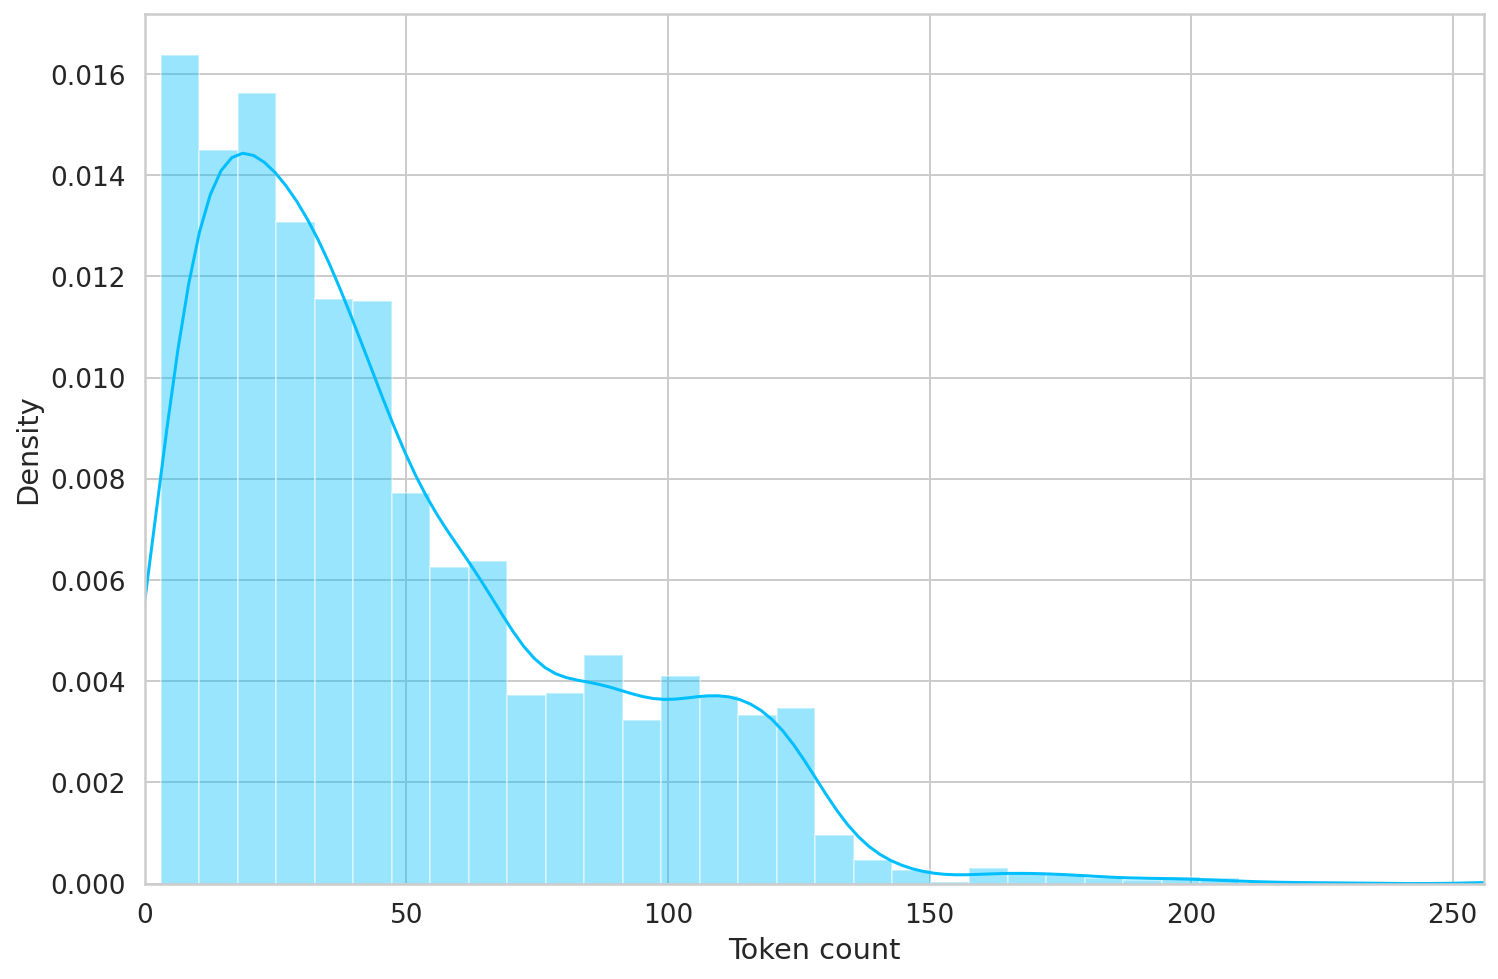

In [28]:
sns.distplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count');

In [29]:
MAX_LEN = 180

In [30]:
# create a PyTorch dataset
class GPReviewDataset(Dataset):
  def __init__(self, reviews, targets, tokenizer, max_len):
    self.reviews = reviews
    self.targets =  targets
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
    return len(self.reviews)
  
  def __getitem__(self, item):
    review = str(self.reviews[item])
    target = self.targets[item]
    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length=self.max_len,
      truncation = True,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
    )

    return {
      'review_text': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [31]:
df_train, df_test = train_test_split(df, test_size = 0.1, random_state = RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size = 0.5, random_state = RANDOM_SEED)

In [32]:
df_train.shape, df_val.shape, df_test.shape

((3600, 12), (200, 12), (200, 12))

In [33]:
def create_data_loader(df, tokenizer, max_len, batch_size,train = False):
  ds = GPReviewDataset(
      # convert tensor to numpy array
      reviews = df.content.to_numpy(),
      targets = df.sentiment.to_numpy(),
      tokenizer = tokenizer,
      max_len = max_len
  )
  return DataLoader(
    ds, 
    batch_size = batch_size,
    num_workers = 4
    )



In [34]:
BATCH_SIZE = 16
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE, train = True)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [35]:
# iterate with the 1st one and next ones in loop
data = next(iter(train_data_loader))
data.keys()

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])

In [36]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)  

torch.Size([16, 180])
torch.Size([16, 180])
torch.Size([16])


In [37]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

Downloading:   0%|          | 0.00/433 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/436M [00:00<?, ?B/s]

In [38]:
last_hidden_state, pooled_output = bert_model(
  input_ids=encoding['input_ids'], 
  attention_mask=encoding['attention_mask']
)

In [39]:
last_hidden_state.shape

torch.Size([1, 32, 768])

In [40]:
bert_model.config.hidden_size

768

In [41]:
pooled_output.shape

torch.Size([1, 768])

Sequence output is the sequence of hidden-states (embeddings) at the output of the last layer of the BERT model. It includes the embedding of the [CLS] token. Hence, for the sentence "You are on Stackoverflow", it gives 5 embeddings: one embedding for each of the four words (assuming the word "Stackoverflow" was tokenized into a single token) along with the embedding of the [CLS] token. Pooled output is the embedding of the [CLS] token (from Sequence output), further processed by a Linear layer and a Tanh activation function. The Linear layer weights are trained from the next sentence prediction (classification) objective during pretraining.

If you have given a sequence, "You are on StackOverflow". The sequence_output will give 768 embeddings of these four words. But, the pooled output will just give you one embedding of 768, it will pool the embeddings of these four words.


In [42]:
#extend from nn module
# Defines a class that extends the Module class. The constructor of the class defines the layers of the model 
# and the forward() function is the overrides that defines how to forward propagate input through the defined layers of the model.
class SentimentClassifier(nn.Module):
  # constructor
  def __init__(self, n_classes):
    # super constructor
    super (SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    # dropout layer with probablity of dropout as 0.3
    self.drop = nn.Dropout(p = 0.3)
    # output layer
    # number of hidden unit size in the bert model(bert.config.hidden_size) and number of classes
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)

  def forward(self, input_ids, attention_mask):
    # skip the last hidden state and just get output of the pooled output from our bert model
    _,pooled_output = self.bert(
        input_ids = input_ids,
        attention_mask= attention_mask
    )
    # output of the dropout layer
    output = self.drop(pooled_output)
    # returns the output of the classifier
    return self.out(output)

In [43]:
# create the instance of the class
model = SentimentClassifier(len(class_names))
model = model.to(device)

In [44]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([16, 180])
torch.Size([16, 180])


In [45]:
model(input_ids,attention_mask)

tensor([[ 0.7456, -0.1789,  0.7661],
        [ 0.4676, -1.0288, -0.0492],
        [ 0.2210, -0.3961,  0.9817],
        [ 0.9257, -0.5974,  0.3652],
        [ 0.6763, -0.5079, -0.1487],
        [ 0.0577, -0.6582,  0.5590],
        [ 0.3912, -0.7240,  0.4378],
        [ 0.0133, -0.1066,  0.3097],
        [ 0.3762, -0.3574,  0.7392],
        [-0.0049, -0.0930,  0.6781],
        [ 0.4030, -0.5443,  0.4161],
        [ 0.8292,  0.0887,  0.7090],
        [ 0.5974, -1.2937,  0.1974],
        [ 0.3357, -0.8644, -0.0162],
        [ 0.6286, -0.2846,  0.7396],
        [ 0.4227, -0.2496,  0.5508]], device='cuda:0', grad_fn=<AddmmBackward>)

In [46]:
# nn.Softmax(model(input_ids, attention_mask), dim=1)

 It corrects weight decay. total_steps for get_linear_schedule_with_warmup(create a schedule with a learning rate that dec linearly after inc during a warmup period)  and num_warmupsteps = 0 as per the bert paper

optimizer (Optimizer) – The optimizer for which to schedule the learning rate.

num_warmup_steps (int) – The number of steps for the warmup phase.

num_training_steps (int) – The total number of training steps.

last_epoch (int, optional, defaults to -1) – The index of the last epoch when resuming training.

In [51]:
EPOCHS = 5

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

# adjust hyperparameter of learning rate
scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

In [52]:
def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  scheduler, 
  n_examples
):
# train the model
  model = model.train()

  losses = []
  correct_predictions = 0
  
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())
    # When you do backward, this info is used to calculate the gradients. These gradients are added to each tensor’s .grad. 
    # When you do step, the optimizer updates the weights based on the gradients. When you do zero_grad, the gradients are set to 0.
    
    # credit assignment
    # loss.backward() computes the derivative of the loss w.r.t. the parameters (or anything requiring gradients) using backpropagation.
    loss.backward()
    # The scheduler gets called every time a batch is fed to the model. 
    # We're avoiding exploding gradients by clipping the gradients of the model using clip_grad_norm_.
    # to overcome exploding gradient
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    # get the step for optimizer and scheduler. this scheduler will be called everytime the example batch loads in data loader
    # update the model weights
    #  The model will only be updated with optimizer.step(), and scheduler.step() will adjust lr.s
    # opt.step() causes the optimizer to take a step based on the gradients of the parameters.
    optimizer.step()
    scheduler.step()
    # to clear the gradients
    # restarts looping without losses from the last step if you use the gradient method for decreasing the error (or losses).
    # zero_grad clears old gradients from the last step (otherwise you’d just accumulate the gradients from all loss.backward() calls). 
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

In [53]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0
# disable the gradient
  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      # to get the most certain prediction
      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

In [54]:
%%time
# history stored as keras lin stores the history

history = defaultdict(list)
best_accuracy = 0
# each update to model involves the pattern:
# clearing the last error gradient,  
# a forward pass of the input through the model, 
# calculating the loss for the model output
# backpropagating the error through the model
# update the model in an effort to reduce the model
for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler, 
    len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn, 
    device, 
    len(df_val)
  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()
# store in history
  history['train_acc'].append(train_acc)  
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    # save the model and put best accuracy to val_acc
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc


Epoch 1/5
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Train loss 0.7735180189874438 accuracy 0.6566666666666666
Val   loss 0.48582231998443604 accuracy 0.77

Epoch 2/5
----------
Train loss 0.38622152179479596 accuracy 0.8605555555555555
Val   loss 0.430729713004369 accuracy 0.85

Epoch 3/5
----------
Train loss 0.17894179137423635 accuracy 0.9463888888888888
Val   loss 0.45186381124389857 accuracy 0.885

Epoch 4/5
----------
Train loss 0.10284321101278894 accuracy 0.9730555555555556
Val   loss 0.4927206476075718 accuracy 0.905

Epoch 5/5
----------
Train loss 0.06773917097391353 accuracy 0.9822222222222222
Val   loss 0.5148233448943267 accuracy 0.895

CPU times: user 18min 58s, sys: 13.3 s, total: 19min 11s
Wall time: 19min 12s


In [ ]:
# !gdown --id 1V8itWtowCYnb2Bc9KlK9SxGff9WwmogA

# model = SentimentClassifier(len(class_names))
# model.load_state_dict(torch.load('best_model_state.bin'))
# model = model.to(device)

In [55]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


0.85

In [66]:
def get_predictions(model, data_loader):
  model = model.eval()
  
  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      texts = d["review_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      # probs = nn.Softmax(outputs, dim=1)
# extends the list(review_texts: raw text
      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(outputs)
      real_values.extend(targets)
# converting to tensor, stack joins the tensors
  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, prediction_probs, real_values

In [67]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model, 
  test_data_loader
)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [68]:
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

    negative       0.88      0.87      0.87        82
     neutral       0.73      0.80      0.77        55
    positive       0.93      0.87      0.90        63

    accuracy                           0.85       200
   macro avg       0.85      0.85      0.85       200
weighted avg       0.85      0.85      0.85       200



In [69]:
review_text = "I love completing my todos! Best app ever!!!"

In [70]:
encoded_review = tokenizer.encode_plus(
  review_text,
  max_length=MAX_LEN,
  truncation = True,
  add_special_tokens=True,
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',
)

In [71]:
input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)

output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)

print(f'Review text: {review_text}')
print(f'Sentiment  : {class_names[prediction]}')

Review text: I love completing my todos! Best app ever!!!
Sentiment  : positive


In [72]:
review_text = "I hate this app, not good at all! worst app ever!!!"

In [73]:
encoded_review = tokenizer.encode_plus(
  review_text,
  max_length=MAX_LEN,
  truncation = True,
  add_special_tokens=True,
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',
)

In [74]:
input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)

output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)

print(f'Review text: {review_text}')
print(f'Sentiment  : {class_names[prediction]}')

Review text: I hate this app, not good at all! worst app ever!!!
Sentiment  : negative


In [81]:
review_text = "not that good app, okay-ish!!!"

In [82]:
encoded_review = tokenizer.encode_plus(
  review_text,
  max_length=MAX_LEN,
  truncation = True,
  add_special_tokens=True,
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',
)

In [83]:
input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)

output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)

print(f'Review text: {review_text}')
print(f'Sentiment  : {class_names[prediction]}')

Review text: not that good app, okay-ish!!!
Sentiment  : neutral
